In [14]:
import sys

sys.path.append("../../src")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.linalg import eigh
import sto_ng
import sto_ng_overlap_function
import h5py
import gaussian_overlap_function


importlib.reload(sto_ng)
importlib.reload(sto_ng_overlap_function)
importlib.reload(gaussian_overlap_function)
from sto_ng import *
from sto_ng_overlap_function import *
from gaussian_overlap_function import *

In [16]:
with h5py.File("../make_base/sto_ng.h5", "r") as f:
    alphas = f["1s/sto-3g/alpha"][:]
    cs = f["1s/sto-3g/c"][:]
alphas = np.array(alphas)
cs = np.array(cs)
cs_new = cs * (2 * alphas / np.pi) ** (3 / 4)

In [17]:
stong = StoNG(cs_new, alphas)
zetaH = 1.24
Rs = [np.array([0, 0, 0]), np.array([0, 0, 1.4])]
zetas = [zetaH, zetaH]


def get_hf_total_energy(stong, zetas, Rs):
    stongmatrix = StoNGMatrix(stong, zetas, Rs)
    c_sto3g = np.array([1, 1])
    s_mat = stongmatrix.get_smat()
    h_mat = stongmatrix.get_h_mat()
    norm = c_sto3g @ s_mat @ c_sto3g
    J_mat = stongmatrix.get_J_mat(c_sto3g) / norm
    return (c_sto3g @ (2 * h_mat + J_mat) @ c_sto3g) / norm + 1 / np.linalg.norm(
        Rs[0] - Rs[1]
    )

In [18]:
def get_ci_total_energy(stong, zetas, Rs):
    stongmatrix = StoNGMatrix(stong, zetas, Rs)
    c0 = np.array([1, 1])
    c1 = np.array([1, -1])
    s_mat = stongmatrix.get_smat()
    h_mat = stongmatrix.get_h_mat()
    norm = c0 @ s_mat @ c0
    J_mat = stongmatrix.get_J_mat(c0) / norm
    E0 = (c0 @ (2 * h_mat + J_mat) @ c0) / norm + 1 / np.linalg.norm(Rs[0] - Rs[1])

    norm = c1 @ s_mat @ c1
    J_mat = stongmatrix.get_J_mat(c1) / norm

    E1 = (c1 @ (2 * h_mat + J_mat) @ c1) / norm + 1 / np.linalg.norm(Rs[0] - Rs[1])
    electron_electron_mat = stongmatrix.get_electron_electron_mat()
    K12 = (
        electron_electron_mat
        @ c1
        @ c1
        @ c0
        @ c0
        / ((s_mat @ c0 @ c0) * (s_mat @ c1 @ c1))
    )
    cimat = np.array([[E0, K12], [K12, E1]])
    val, vec = eigh(cimat)
    return val[0]

In [19]:
rs = np.linspace(0.5, 6, 100)
Rss = [np.array([[0, 0, 0], [0, 0, r]]) for r in rs]
hf_total_energies = np.array([get_hf_total_energy(stong, zetas, Rs) for Rs in Rss])
ci_total_energies = np.array([get_ci_total_energy(stong, zetas, Rs) for Rs in Rss])

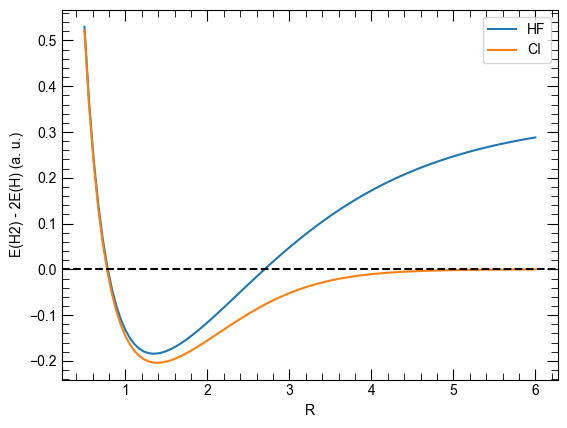

In [20]:
fig, ax = plt.subplots()
ax.plot(rs, hf_total_energies + 2 * 0.4666, label="HF")
ax.plot(rs, ci_total_energies + 2 * 0.4666, label="CI")
ax.axhline(0, color="black", linestyle="--")
ax.set_xlabel("R")
ax.set_ylabel("E(H2) - 2E(H) (a. u.)")
ax.legend()